# Making a predictive model for used car sales, and using gradient boosting to improve performance #

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In this project I will prepare the data by adding new features, removing irrelevant features, and by removing data points that are incorrectly stored. Then I will build several different predictive models and clock them to analyze which model produces the highest quality prediction optimized with fast training and predictions.

## Data preparation

In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn.metrics
import time

# preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# model tuning
from sklearn.model_selection import GridSearchCV

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor

# evalutation
from sklearn.metrics import mean_squared_error

In [4]:
# Read the CSV and then take a first look at the data
df = pd.read_csv('car_data.csv')
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Clean the column names ###

In [ ]:
# Rename the columns to be in snake case
df = df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [ ]:
# use describe to observe the numerical features
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


The number of pictures column has no values in it. As a result, it will be best to simply drop it from this set.
The registration year feature is also odd as it has values that can't make sense: a car from year 1000, and a car from sometime in the future 9999. These outliers need to be removed. Then, there are appantly cars that have a 0 in the power column as well as some with HP of 20,000. These observations impossible, so those datapoints will need to be removed. 

In [ ]:
#remove the number_of_pictures column as irrelevant
df.drop('number_of_pictures', axis=1, inplace=True)

# drop the postal_code column as irrelevant data
df.drop('postal_code', axis=1, inplace=True)

In [ ]:
# remove unrealistic data outliers
df = df[(df['registration_year'] >= 1900) & (df['registration_year'] <= 2023)]
df = df[(df['power'] >= 50) & (df['power'] <= 3000)]

In [ ]:
# Check for duplicates in the data
df.duplicated().sum()

# Verify that the duplicate rows are in fact fully duplicated
# Identify duplicate rows
duplicates = df[df.duplicated(keep=False)]  # keep=False ensures that all duplicates are shown, not just the second and onward.

# Sort the duplicates to group identical rows together
duplicates_sorted = duplicates.sort_values(by=df.columns.tolist())

# Display the duplicates side by side (if you want to compare rows directly)
display(duplicates_sorted)

# Drop the duplicates
df = df.drop_duplicates()


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,last_seen
87112,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,07/04/2016 06:15
90786,01/04/2016 05:02,6199,coupe,1999,manual,193,3er,150000,5,petrol,bmw,no,01/04/2016 00:00,07/04/2016 06:15
45825,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,07/04/2016 06:46
142496,01/04/2016 10:38,3499,small,2005,manual,86,getz,50000,5,petrol,hyundai,no,01/04/2016 00:00,07/04/2016 06:46
12578,01/04/2016 12:57,1499,wagon,1995,manual,150,5er,150000,6,petrol,bmw,no,01/04/2016 00:00,07/04/2016 09:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190213,31/03/2016 19:51,999,small,1998,manual,60,corsa,150000,5,petrol,opel,no,31/03/2016 00:00,06/04/2016 14:18
27192,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,06/04/2016 14:15
228351,31/03/2016 20:25,9600,sedan,2006,manual,226,focus,125000,4,petrol,ford,no,31/03/2016 00:00,06/04/2016 14:15
30499,31/03/2016 23:51,5999,wagon,2007,manual,120,astra,150000,3,gasoline,opel,no,31/03/2016 00:00,07/04/2016 00:17


In [ ]:
df.describe()

,price,registration_year,power,mileage,registration_month
count,307776.000000,307776.000000,307776.000000,307776.000000,307776.000000
mean,4760.057675,2003.395508,122.799848,128743.339312,5.944791
std,4601.577390,6.783914,66.502212,36561.777605,3.611807
min,0.000000,1910.000000,50.000000,5000.000000,0.000000
25%,1299.000000,1999.000000,80.000000,125000.000000,3.000000
50%,3000.000000,2003.000000,114.000000,150000.000000,6.000000
75%,6900.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,2799.000000,150000.000000,12.000000


In [ ]:
display(df['registration_year'].sort_values())

74814     1910
321782    1910
93104     1910
203230    1910
302641    1910
          ... 
264473    2019
74469     2019
57074     2019
35506     2019
148759    2019
Name: registration_year, Length: 307776, dtype: int64

### What should be done with the date columns? ###

There are a couple issues with the date columns that we can clean up to aid learning. Date Crawled and Date Created are two data points that don't help a whole lot. Instead, by subtrating the date created from the last seen information we can get a new feature: listing length.

Also, the registration year and month columns don't offer much value by themselves, but they could potentially be used to calculate the vehicle age by subtracting them from the last seen column. That information could be connected to trends in the data and be helpful for predicting the price.

In [ ]:
# Checking to see what the difference between the date columns really is
df['date_crawled'] = pd.to_datetime(df['date_crawled']).dt.date
df['date_created'] = pd.to_datetime(df['date_created']).dt.date
df['last_seen'] = pd.to_datetime(df['last_seen']).dt.date

# Now compare the two date columns
date_comparison = df[['date_crawled', 'date_created']]

# Check for rows where the dates are different
date_comparison['date_difference'] = date_comparison['date_crawled'] != date_comparison['date_created']

# Display the last 10 rows to inspect
display(date_comparison.tail(10))

/tmp/ipykernel_50/2693084873.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_comparison['date_difference'] = date_comparison['date_crawled'] != date_comparison['date_created']


,date_crawled,date_created,date_difference
354355,2016-03-21,2016-03-21,False
354356,2016-04-04,2016-04-04,False
354357,2016-09-03,2016-09-03,False
354358,2016-04-04,2016-04-04,False
354359,2016-03-28,2016-03-28,False
354361,2016-09-03,2016-09-03,False
354362,2016-03-19,2016-03-19,False
354366,2016-05-03,2016-05-03,False
354367,2016-03-19,2016-03-19,False
354368,2016-03-20,2016-03-20,False


In [ ]:
# Check if there are any differences across the entire DataFrame
any_difference = date_comparison['date_difference'].any()

# Display the result
if any_difference:
    print("There are differences between 'date_crawled' and 'date_created'.")
else:
    print("There are no differences between 'date_crawled' and 'date_created'.")

There are differences between 'date_crawled' and 'date_created'.


In [ ]:
# Filter the rows where the dates differ
rows_with_differences = date_comparison[date_comparison['date_difference'] == True]

# Display those rows
display(rows_with_differences)

,date_crawled,date_created,date_difference
42,2016-03-24,2016-03-23,True
47,2016-04-04,2016-03-04,True
67,2016-03-21,2016-09-02,True
99,2016-03-28,2016-03-27,True
178,2016-03-21,2016-03-20,True
...,...,...,...
354298,2016-03-26,2016-03-25,True
354328,2016-08-03,2016-07-03,True
354331,2016-03-15,2016-03-14,True
354345,2016-01-04,2016-03-31,True


### Findings about the Date Columns ###
While most of the rows of data have the date_crawled and date_created as the same information, there is a significant portion of the data where the dates are not the same. By looking closer at how they are different, there are some times when the date_crawled is earlier and some times when it is later than the date_created column. Having two columns for similar information is not helpful to the overall goal of creating a predictive model for the price. Instead, I'm going to subtract the date_created column from the last_seen column to get a new feature - listing_length. This feature can be counted in days, and be usable for our overall model development.

### Feature Engineering ###
In addition to adding a listing length column and removing the last seen, date created, and date crawled columns, I will also create a new age of vehicle column. Then I'll be able to remove the registration year and month columns. I will also remove the postal code column because it is not relevant to the overall goals of the models I will be writing later in this project.

In [ ]:
# Add listing_length feature, and making sure that it is as days
df['listing_length'] = (df['last_seen'] - df['date_created']).dt.days

# convert listing_length to int
df['listing_length'] = df['listing_length'].astype('int64')

In [ ]:
# Ensure 'date_created' is in datetime format
df['last_seen'] = pd.to_datetime(df['last_seen'])

# Combine 'registration_year' and 'registration_month' to create a full registration date
df['registration_date'] = pd.to_datetime(
    df['registration_year'].astype(str) + '-' + df['registration_month'].astype(str) + '-01',
    format='%Y-%m-%d',
    errors='coerce'  # Handle invalid dates
)

# Calculate the difference in years (vehicle age)
df['vehicle_age'] = (df['last_seen'] - df['registration_date']).dt.days / 365

# Handle NaN values in 'vehicle_age' (e.g., due to invalid/missing registration dates)
df['vehicle_age'] = df['vehicle_age'].fillna(-1)  # Replace NaN with a default value (-1)

# Round to the nearest integer and cast as int64
df['vehicle_age'] = df['vehicle_age'].round().astype('int64')

# Drop the intermediate 'registration_date' column if not needed
df.drop('registration_date', axis=1, inplace=True)

# Preview the result
display(df[['last_seen', 'registration_year', 'registration_month', 'vehicle_age']].head())



,last_seen,registration_year,registration_month,vehicle_age
1,2016-07-04,2011,5,5
2,2016-05-04,2004,8,12
3,2016-03-17,2001,6,15
4,2016-06-04,2008,7,8
5,2016-06-04,1995,10,21


In [ ]:
df = df[(df['vehicle_age'] > 0) & (df['vehicle_age'] < 40)]

In [ ]:
# remove the unneeded columns
df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1, inplace=True)

Registration year and month don't really seem to add much value for the overall picture of this project. Instead of dropping them altogther, I think that it would be a helpful feature to have a time since the vehicle was originally registered. This would be then speak to the actual age of the vehicle, and the int64 value would actually mean something. As they currently exist, each year and month is more like a category than a numerical feature. So, I will subtract the registration year and month from the last seen column to get an age of vehicle feature. Then I can drop the registration year and month columns.

In [ ]:
# remove the registration year and month features
df.drop(['registration_year', 'registration_month'], axis=1, inplace=True)

In [ ]:
# verify the changes made
display(df.head())

,price,vehicle_type,gearbox,power,model,mileage,fuel_type,brand,not_repaired,listing_length,vehicle_age
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,102,5
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,51,12
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,0,15
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,65,8
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,61,21


### Explore NaN values ###

In [ ]:
# What percentage of each column is NaN?
display(df.isna().sum()/len(df)*100)

price              0.000000
vehicle_type       1.146275
gearbox            1.239226
power              0.000000
model              3.031016
mileage            0.000000
fuel_type          3.425231
brand              0.000000
not_repaired      11.954693
listing_length     0.000000
vehicle_age        0.000000
dtype: float64

### NaN Value conclusions and plan ###
NaN values make up a significant portion of this data, specifically in the following columns: vehicle_type, gearbox, model, fuel_type, not_repaired. Because of this we will have to fill these in order to effectively train our data. Since all of these columns are object type data, I'm going to fill them with the string 'unknown'. Then I'll be able to do One Hot encoding for these columns to gain a usable dataset for our Machine learning training.

In [ ]:
# Fill NaN with 'Unknown'
df.fillna('unknown', inplace=True)

#verify all NaN values are filled
display(df.isna().sum()/len(df)*100)

price             0.0
vehicle_type      0.0
gearbox           0.0
power             0.0
model             0.0
mileage           0.0
fuel_type         0.0
brand             0.0
not_repaired      0.0
listing_length    0.0
vehicle_age       0.0
dtype: float64

### Exploration and preparation of the Object Columns ###
Since several of the columns are of the object dtype, I'm going to use one hot encoding to give them numerical values. In order to do this, I will need to look more closely at each of the columns needing to be encoded. For columns such as model: I will likely have to remove some of the data due to there being so many different models of vehicles. If there isn't enough data to make good predictive decisions, I will be removing it in service of having a more simplified dataset to build my learning models on.

### Feature Visualizations

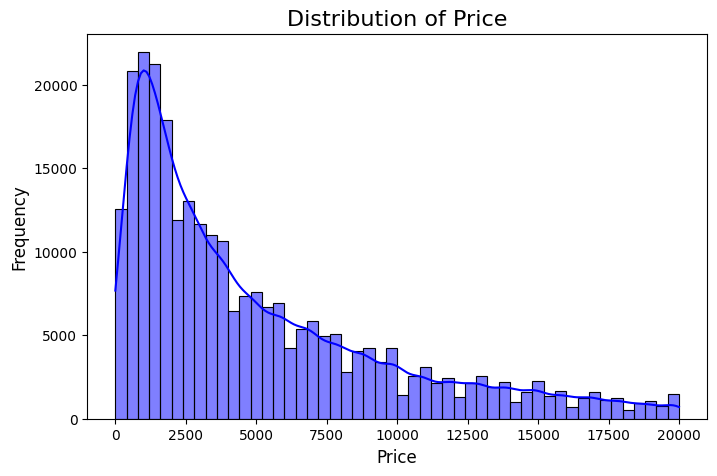

In [ ]:
# make a histogram of the target column
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title('Distribution of Price', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

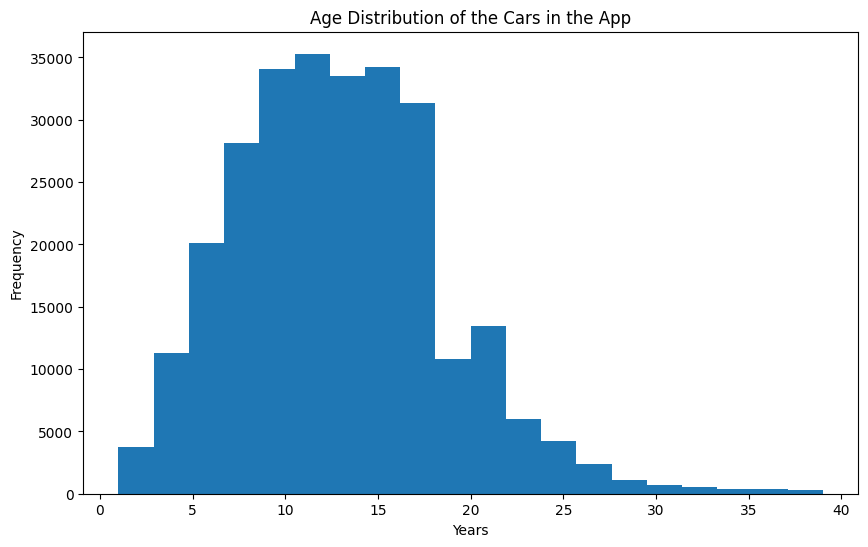

In [ ]:
# make a histogram of the age column
plt.figure(figsize=(10,6))
plt.hist(df['vehicle_age'], bins=20)
plt.title('Age Distribution of the Cars in the App')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

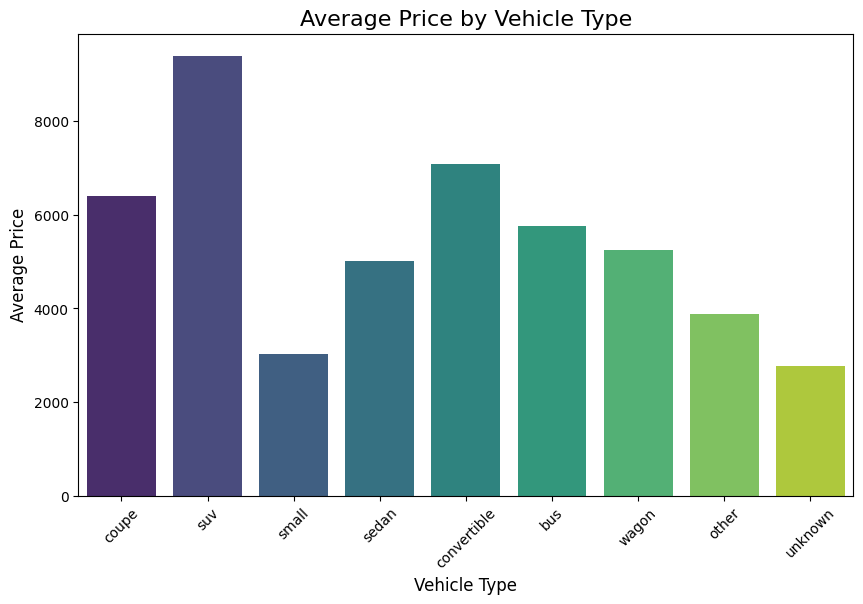

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='vehicle_type', y='price', ci=None, palette='viridis')
plt.title('Average Price by Vehicle Type', fontsize=16)
plt.xlabel('Vehicle Type', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.xticks(rotation=45)
plt.show()

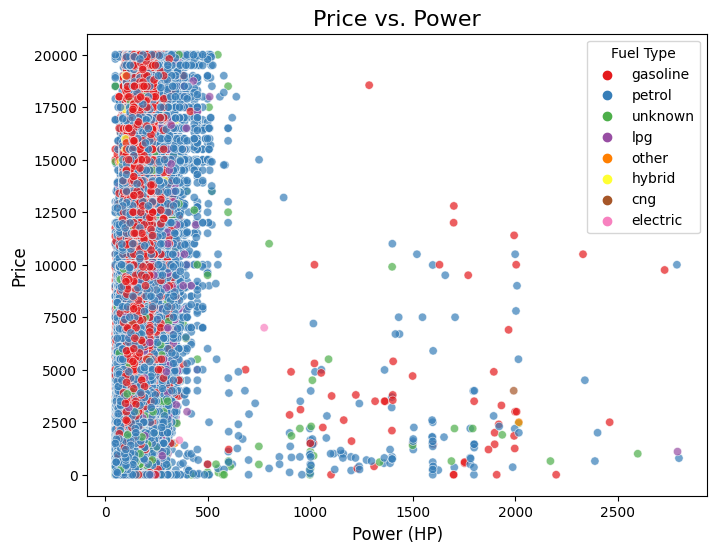

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='power', y='price', hue='fuel_type', palette='Set1', alpha=0.7)
plt.title('Price vs. Power', fontsize=16)
plt.xlabel('Power (HP)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(title='Fuel Type')
plt.show()

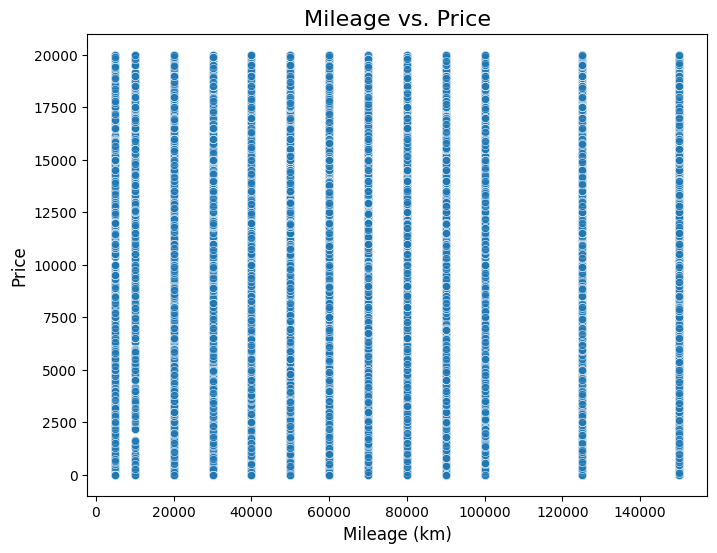

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='mileage', y='price', palette='cool', alpha=0.7)
plt.title('Mileage vs. Price', fontsize=16)
plt.xlabel('Mileage (km)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

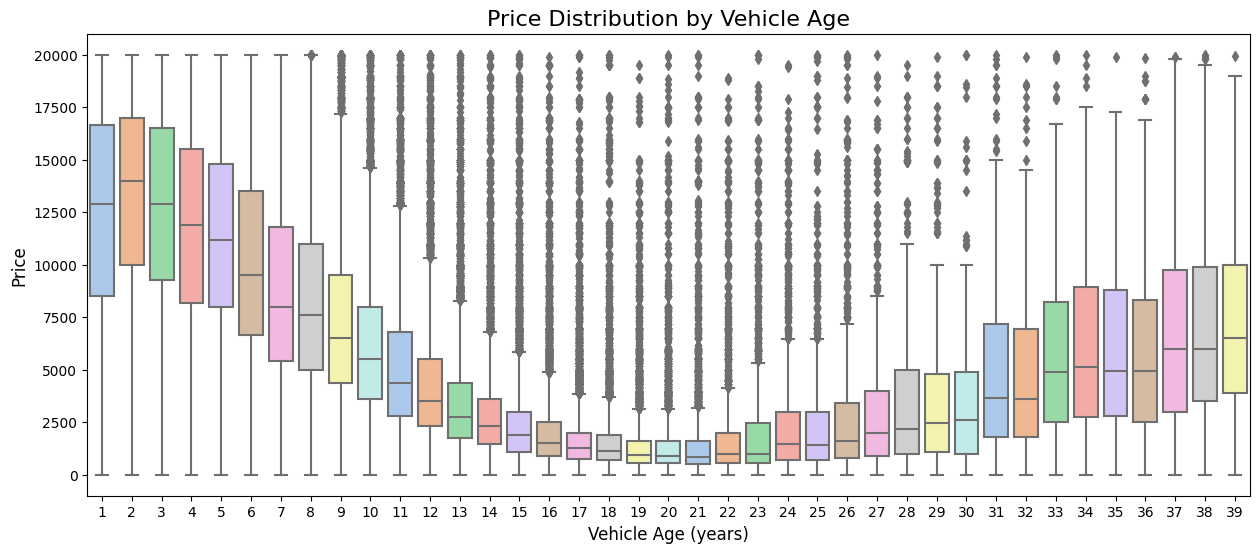

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='vehicle_age', y='price', palette='pastel')
plt.title('Price Distribution by Vehicle Age', fontsize=16)
plt.xlabel('Vehicle Age (years)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

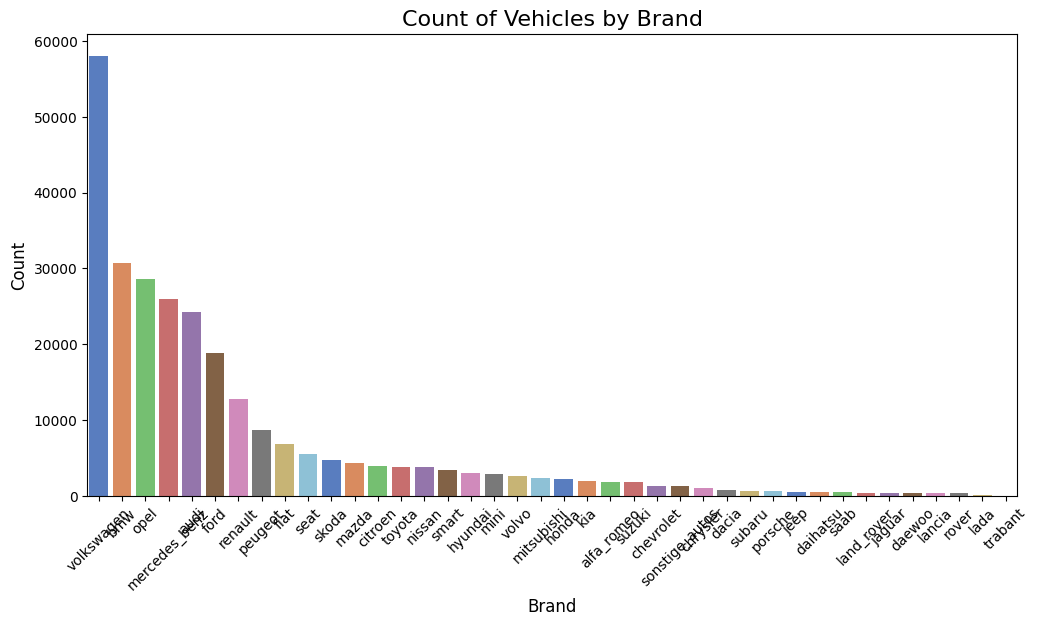

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='brand', order=df['brand'].value_counts().index, palette='muted')
plt.title('Count of Vehicles by Brand', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

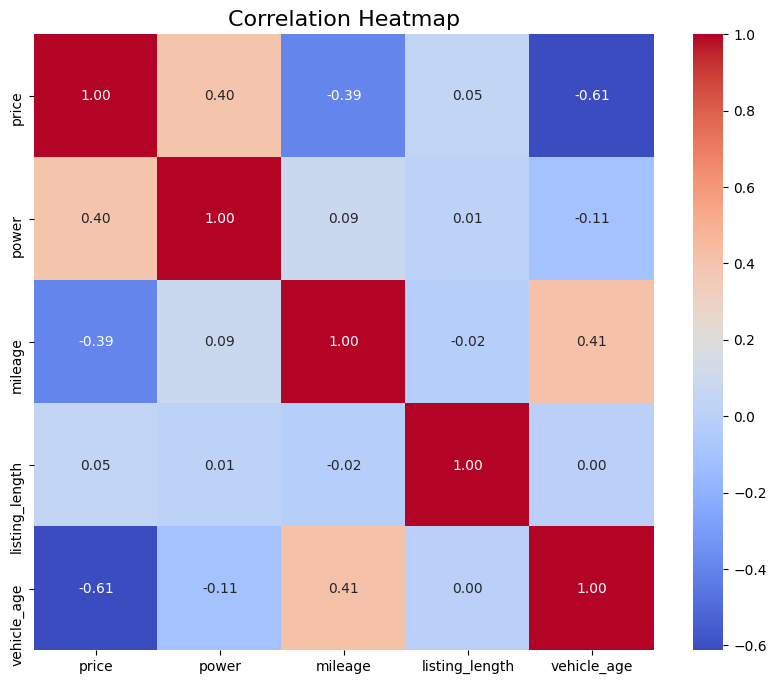

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[['price', 'power', 'mileage', 'listing_length', 'vehicle_age']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

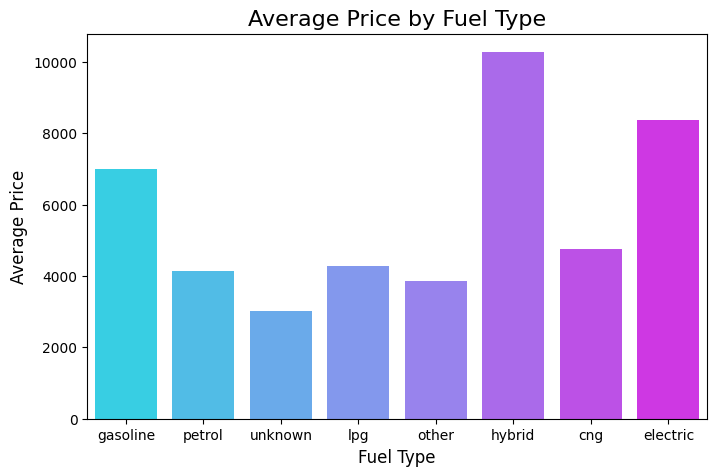

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='fuel_type', y='price', ci=None, palette='cool')
plt.title('Average Price by Fuel Type', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.show()

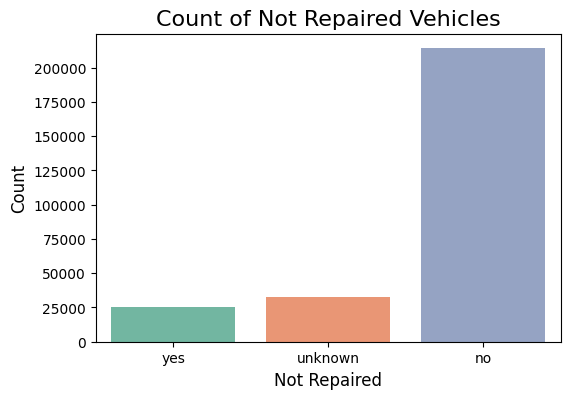

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='not_repaired', palette='Set2')
plt.title('Count of Not Repaired Vehicles', fontsize=16)
plt.xlabel('Not Repaired', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

#### Chart Conclusions ####
There is a heavy skew in the price column toward less exspenive vehicles. While there are some that sell for closer to 20,000 Euros, most are in the below 5000 range. This means that a high prediction error will be doubly felt by the lower cost of most vehicles.

Most of the cars that we're going to be using for our models fall within the 5-20 year range, but there are several outside of that as well. And the age does seem to have an effect on the value of the vehicle as it bottoms out around 20 years old. Newer vehicles have a higher pricepoint as do the older vehicles. 

The vehicle type with the highest price points are the SUVs followed by coupes and convertibles. This seems to be a feature that will have good predictive value for our models later on. The available brands in this dataset show that the VW brand is the most common, and there is a long tail of less often seen brands. with only 7 of the total brands having more than 10,000 observations. Currently, the hybrid and electric fuel type vehicles are fetching the best prices in this data. 


#### Explanation of decision about small amounts of data ###
Since there are only 256 rows of data from the cars that have 30 or less observations, I'm going to be removing them from the whole dataset. It doesn't make sense to have additional columns of information later on for our Learning Models that are only represented by such a small dataset. By clearing out these small data pieces it should help the overal functioning of the models in the end.

### Target and Features Preparation

In [ ]:
# Identify the features and target
X = df.drop('price', axis=1)
y = df['price']      

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8420)

In [ ]:
# Define numerical and categorical columns
numerical_columns = ['power', 'mileage', 'listing_length', 'vehicle_age']
categorical_columns = ['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']

In [ ]:
# Scale the numerical features
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Apply one-hot encoding using get_dummies
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Align the training and test sets to ensure they have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill any missing columns in the test set with zeros
X_test = X_test.fillna(0)

/tmp/ipykernel_50/881289967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
/opt/conda/envs/python3/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_50/881289967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

## Model training

In [ ]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, **hyperparameters):
    # Set the hyperparameters of the model
    model.set_params(**hyperparameters)
    
    # Measure training time
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train
    
    # Measure prediction time
    start_pred = time.time()
    predictions = model.predict(X_test)
    end_pred = time.time()
    pred_time = end_pred - start_pred
    
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    return rmse, train_time, pred_time

### Decision Tree ###

In [ ]:
%%time
dt_model = DecisionTreeRegressor()
hyperparameters = {"max_depth": 10, "min_samples_split": 10, "min_samples_leaf": 5}
rmse, train_time, pred_time = train_evaluate_model(dt_model, X_train, y_train, X_test, y_test, **hyperparameters)
print(f"RMSE: {rmse}")
print(f"Train time:{train_time:.2f}seconds")
print(f"Prediction time: {pred_time:.2f}seconds")

RMSE: 2013.0924339212709
Train time:2.10seconds
Prediction time: 0.04seconds
CPU times: user 2.07 s, sys: 72.1 ms, total: 2.14 s
Wall time: 2.14 s


### Random Forest ###

In [ ]:
%%time
rf_model = RandomForestRegressor(random_state=8420)
hyperparameters = {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 10}
rmse, train_time, pred_time = train_evaluate_model(rf_model, X_train, y_train, X_test, y_test, **hyperparameters)
print(f"RMSE: {rmse}")
print(f"Train time:{train_time:.2f}seconds")
print(f"Prediction time: {pred_time:.2f}seconds")

RMSE: 1610.2345166603657
Train time:197.95seconds
Prediction time: 1.74seconds
CPU times: user 3min 19s, sys: 94.2 ms, total: 3min 19s
Wall time: 3min 19s


### Linear Regression ###

Use this as a sanity check to make sure that the other models with the hyperparameter tuning are out performing this one.

In [ ]:
%%time
lr_model = LinearRegression()
hyperparameters = {}
rmse, train_time, pred_time = train_evaluate_model(lr_model, X_train, y_train, X_test, y_test, **hyperparameters)
print(f"RMSE: {rmse}")
print(f"Train time:{train_time:.2f}seconds")
print(f"Prediction time: {pred_time:.2f}seconds")

RMSE: 2492.0919495250773
Train time:7.01seconds
Prediction time: 0.10seconds
CPU times: user 5.98 s, sys: 1.18 s, total: 7.16 s
Wall time: 7.12 s


### Gradient Boosting

In [ ]:
%%time
gbr = GradientBoostingRegressor(random_state=8420)
hyperparameters = {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}
rmse, train_time, pred_time = train_evaluate_model(gbr, X_train, y_train, X_test, y_test, **hyperparameters)
print(f"RMSE: {rmse}")
print(f"Train time:{train_time:.2f}seconds")
print(f"Prediction time: {pred_time:.2f}seconds")

RMSE: 1810.9001980860012
Train time:113.26seconds
Prediction time: 0.31seconds
CPU times: user 1min 53s, sys: 86.9 ms, total: 1min 53s
Wall time: 1min 53s


### XGB Regressor ###

In [ ]:
%%time
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=8420)
hyperparameters = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'colsample_bytree': .3, 'alpha': 10}
rmse, train_time, pred_time = train_evaluate_model(xg_reg, X_train, y_train, X_test, y_test, **hyperparameters)
print(f"RMSE: {rmse}")
print(f"Train time:{train_time:.2f}seconds")
print(f"Prediction time: {pred_time:.2f}seconds")

RMSE: 1737.170892946494
Train time:83.05seconds
Prediction time: 0.48seconds
CPU times: user 1min 23s, sys: 366 ms, total: 1min 23s
Wall time: 1min 23s


### Catboost Regressor ###

In [ ]:
X = df.drop('price', axis=1)
y = df['price']

X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X, y, test_size=0.25, random_state=8420)


In [ ]:
categorical_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
categorical_indices = [X_train_C.columns.get_loc(col) for col in categorical_columns]

In [ ]:
%%time
cb_reg = CatBoostRegressor(cat_features=categorical_indices, silent=True, random_state=8420)
hyperparameters = {'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
rmse, train_time, pred_time = train_evaluate_model(cb_reg, X_train_C, y_train_C, X_test_C, y_test_C, **hyperparameters)
print(f'RMSE: {rmse}')
print(f"Train time:{train_time:.2f}seconds")
print(f"Prediction time: {pred_time:.2f}seconds")

RMSE: 1534.9137134183004
Train time:413.01seconds
Prediction time: 0.84seconds
CPU times: user 6min 52s, sys: 486 ms, total: 6min 53s
Wall time: 6min 53s


### LGBM Regressor

In [ ]:
categorical_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'not_repaired']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Train/test split
X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(X, y, test_size=0.25, random_state=8420)


In [ ]:
%%time
lgbm = LGBMRegressor(random_state=8420)
hyperparameters = {'n_estimators': 175, 'max_depth': 20, 'num_leaves': 80, 'learning_rate': 0.2}
rmse, train_time, pred_time = train_evaluate_model(lgbm, X_train_L, y_train_L, X_test_L, y_test_L, **hyperparameters)
print(f'RMSE: {rmse}')
print(f"Train time:{train_time:.2f}seconds")
print(f"Prediction time: {pred_time:.2f}seconds")

RMSE: 1551.4186275897277
Train time:4.41seconds
Prediction time: 0.82seconds
CPU times: user 5.24 s, sys: 52.2 ms, total: 5.29 s
Wall time: 5.23 s


## Model analysis

In [ ]:
# Data
data = {
    "Model": [
        "Decision Tree",
        "Random Forest",
        "Linear Regression",
        "Gradient Boosting",
        "XGBoost",
        "CatBoost",
        "LGBM"
    ],
    "RMSE (€)": [2013, 1610, 2492, 1810, 1737, 1534, 1551],
    "Train Time (s)": [2.1, 197.95, 7.01, 113.26, 83.05, 413.01, 4.41],
    "Predict Time (s)": [0.04, 1.74, 0.1, 0.31, 0.48, 0.84, 0.82]
}

# Create DataFrame
results = pd.DataFrame(data)

# Display the DataFrame
display(results)


,Model,RMSE (€),Train Time (s),Predict Time (s)
0,Decision Tree,2013,2.10,0.04
1,Random Forest,1610,197.95,1.74
2,Linear Regression,2492,7.01,0.10
3,Gradient Boosting,1810,113.26,0.31
4,XGBoost,1737,83.05,0.48
5,CatBoost,1534,413.01,0.84
6,LGBM,1551,4.41,0.82


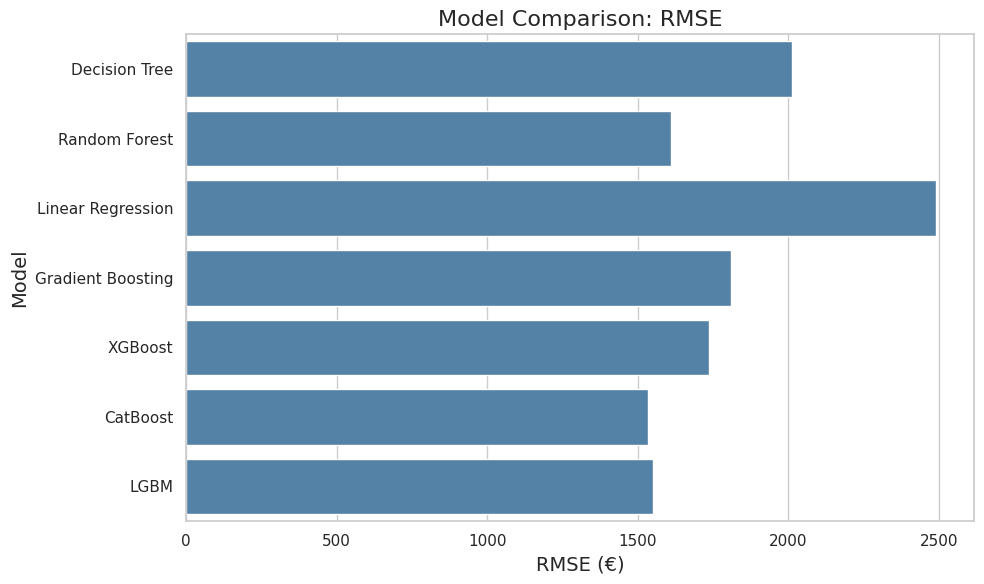

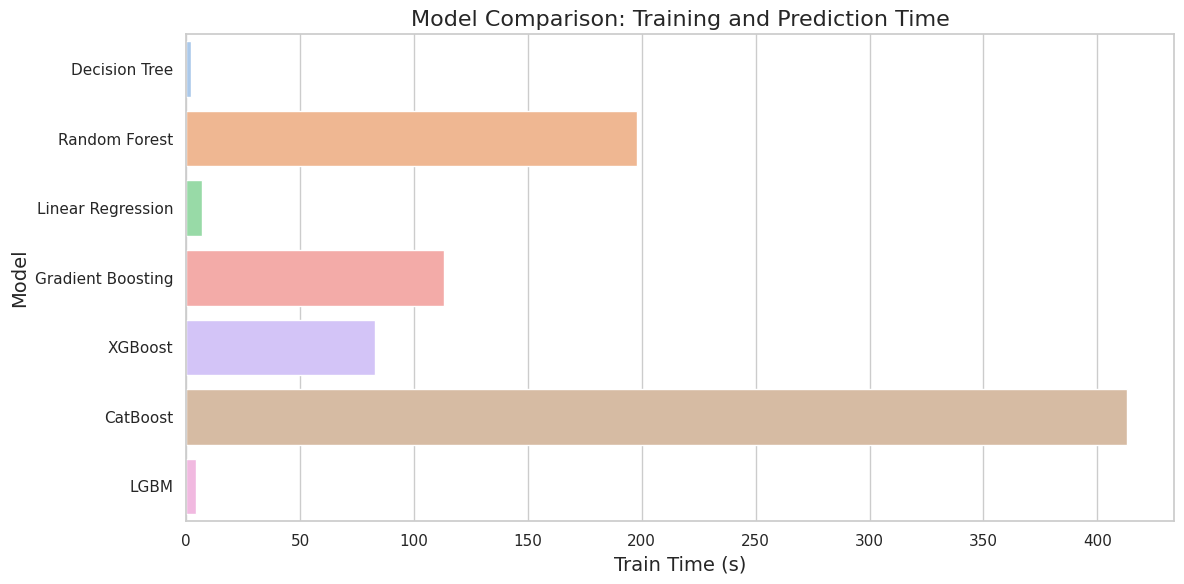

In [ ]:
# Set a consistent style
sns.set(style="whitegrid", palette="pastel")

# Bar chart: RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x="RMSE (€)", y="Model", data=results, color="steelblue")
plt.title("Model Comparison: RMSE", fontsize=16)
plt.xlabel("RMSE (€)", fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.tight_layout()
plt.show()

# Grouped bar chart: Training Time and Prediction Time
plt.figure(figsize=(12, 6))
sns.barplot(x="Train Time (s)", y="Model", data=results)
plt.title("Model Comparison: Training and Prediction Time", fontsize=16)
plt.xlabel("Train Time (s)", fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.tight_layout()
plt.show()

## Conclusions ##



Rusty Bargain requested that I build a quality model that predicts the value of used cars effective while also being efficient in the time it takes to train and predict those values.

In this project I've applied EDA to the car_data CSV file and prepared it for machine learning training. The original data had a few columns that were unnecessary to the overall model building process, so those columns were deleted. There were also a few columns that required some work to make useful information such as amount of time that the car has been listed and the age of the vehicle. There was some data that did not contain values that made sense and so those values were removed.

Once the data was cleaned and prepared, I split the data into training and testing sets with a 25% split. Then I used the data to compare seven different machine learning regression models: Decision Tree, Random Forest, Linear Regression, Gradient Boosting, XG Boosting, Cat Boosting, and Light GBM. The aim was to find the lowest RMSE value in the least amount of time. Above are the results of that training. The LGBM model performed most efficiently in these categories by placing second best in RMSE (second only to catboost), and second fastest in Train and Predict times (second only to Decision tree). 

The Catboost model performed exceptionally well in the RMSE with a value of only 1534, but the trade off was the time it took to tune the hyperparameters and run the model. LightGBM was able to get tuned faster and produce nearly as effective of predictions to the Catboost model. 

My recommendation is that Rusty Bargain use the LightGBM training model for their app.